# Capstone Assignment: Toronto VS New York City
  
### 02 Nov 2019


## 1. Introduction

New York (also called New York City, short form NYC) is the biggest city in the United
States, located in the state of New York. Over 8 million people live in it, and over 22
million people live in the bigger New York metropolitan area. It is in the south end of the
state of New York, which is in the northeastern United States. It is the financial capital of
the US since it is home to the nation's stock market, Wall Street, and the One World
Trade Center. It is also the home of the United Nations Headquarters. The central and
oldest part of the city is Manhattan.

Toronto is the capital city of the province of Ontario in Canada. It is also the largest
city in both Ontario and Canada. Found on the north-west side of Lake Ontario, the City
of Toronto has a population of over 3 million people and even more people live in
the regions around it. All together, the Greater Toronto Area is home to over 6 million
people making it the biggest metropolitan area in Canada. Toronto is the fourth-largest
metropolitan area in North America behind Los Angeles, New York, and Chicago

For years, Toronto and New York City have been pitted against each other in a noholds-
barred comparison to determine which is the better city. New York is clearly the
more famous, with its well-known history and touristy flair. But how does it compare to
Toronto when it comes to cost of living? A general guess is that it's the pricer of the two,
but it's not until you take a look at the numbers that you realize just how much pricier it
really is.

![Toronto Vs New York Photo from public website](TorontoVsNewYork01.jpg)

What we try to do in this report is to explore the neighborhoods of both cities, and show the similarity and difference of its different areas by the clustering method on the combined data of both cities. It could provide good guidance for selecting right neighborhood which fits well for their living style. It is particularly useful for people relocating from New York to Toronto or from Toronto to New York.

## 2. Loading & Cleaning & Preparing Neighbour data in Toronto and New York 
### Scrape data from Wikipedia page, and wrangle the data, clean it, and then read it into a pandas dataframe 
New York: https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json

Toronto: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
# import libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup # library to parse HTML and XML documents
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


## Toronto Data 

In [3]:
# send the GET request
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(source.text, 'html.parser')
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [4]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):              #tr: table row
    cells = row.find_all('td')                             #td: table data
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [5]:
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [6]:
# drop cells with a borough that is Not assigned
toronto_df_1 = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df_1.head()

#remove duplicates.
toronto_df_1 = toronto_df_1.drop_duplicates()

In [7]:
# group neighborhoods in the same borough
toronto_df_grouped = toronto_df_1.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
# print the number of rows of the  dataframe
toronto_df_grouped.shape

(103, 3)

In [10]:
# load the coordinates from the csv file on Coursera
coordinates = pd.read_csv("Geospatial_Coordinates.csv")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
#merge two table on the column "PostalCode"
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()
print(toronto_df_new.shape)

(103, 5)


In [13]:
# Use geopy library to get the latitude and longitude values of Toronto¶
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude_tor = location.latitude
longitude_tor = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_tor, longitude_tor))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
# create a new DataFrame with only boroughs that contain the word Toronto
neighborhoods_tor = toronto_df_new[toronto_df_new['Borough'].str.contains('Toronto')].reset_index(drop=True)
print(neighborhoods_tor.shape)
neighborhoods_tor.head()

(38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## New York City Data 

In [15]:
!wget -q -O newyork_data.json https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


In [16]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [17]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_mah = location.latitude
longitude_mah = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude_mah, longitude_mah))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## 3. Combine & display the neighborhoods from two cities

In [18]:
# get central latitude and longitude
centerLatitude = (latitude_mah + latitude_tor)/2
centerLongitude = (longitude_mah + longitude_tor)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))


The geograpical central coordinates are 42.22179345, -76.67355045.


In [19]:
# Append New York and Toronto tables
tmp = neighborhoods_tor.drop("PostalCode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
75,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
76,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


In [20]:
# Visualize combined neighborhoods in a map using *Folium*
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

In [21]:
from folium.plugins import MiniMap

map_tony = folium.Map(location=[latitude_mah, longitude_mah], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (latitude_mah, longitude_mah), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (latitude_tor, longitude_tor), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony


In [22]:
map_tony = folium.Map(location=[latitude_tor, longitude_tor], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (latitude_mah, longitude_mah), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (latitude_tor, longitude_tor), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

## 4. Use the Foursquare API to explore the neighborhoods

In [23]:
# define Foursquare Credentials and Version
CLIENT_ID = '04YPCXN4IVBOEJR1DOH4WTWM22XRZSKDSZAA0FZ2FZRVCBJO' # your Foursquare ID
CLIENT_SECRET = 'DBHGQDYQVNO3YWGV2BJ5UPJBFOSZLBJOHKW2YZZVMOYGEUUT' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 04YPCXN4IVBOEJR1DOH4WTWM22XRZSKDSZAA0FZ2FZRVCBJO
CLIENT_SECRET:DBHGQDYQVNO3YWGV2BJ5UPJBFOSZLBJOHKW2YZZVMOYGEUUT


In [24]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)    

In [25]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | The Beaches
42 | The Danforth West, Riverdale
43 | The Beaches West, India Bazaar
44 | Studio District
45 | Lawrence Park
46 | Davisville North
47 | North Toronto West
48 | Davisville
49 | Moore Park, Summerhill East
50 | Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West


In [26]:
# Check the size of dataframe
print(tony_venues.shape)
tony_venues.head()

(5016, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,Manhattan,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,Manhattan,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,Manhattan,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,Manhattan,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,Manhattan,40.876551,-73.91066,Blink Fitness Riverdale,40.877147,-73.905837,Gym


In [27]:
# Function to sort venues in decscending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
# How many venues were returned for each neighborhood?
tony_venues.groupby('Neighborhood').count()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100,100
Battery Park City,100,100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56,56
...,...,...,...,...,...,...,...
Washington Heights,86,86,86,86,86,86,86
West Village,100,100,100,100,100,100,100
Yorkville,100,100,100,100,100,100,100


In [29]:
# How many unique categories amongst the returned venues?
print('There are {} uniques categories.'.format(len(tony_venues['Venue Category'].unique())))

There are 375 uniques categories.


In [30]:
# One hot encoding and grouping by neighborhoods
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
#tony_onehot['Borough'] = tony_venues['Borough']
#tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
#tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

# Group rows by neighborhood and mean of frequency for each category
tony_grouped = tony_onehot.groupby(['Neighborhood']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pho

In [31]:
# Report 5 most common venues for each neighborhood
num_top_venues = 5

for hood in tony_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tony_grouped[tony_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2                  Bar  0.04
3           Restaurant  0.03
4  American Restaurant  0.03


----Battery Park City----
           venue  freq
0           Park  0.08
1    Coffee Shop  0.07
2          Hotel  0.05
3            Gym  0.04
4  Memorial Site  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1  Italian Restaurant  0.04
2      Farmers Market  0.04
3            Beer Bar  0.04
4  Seafood Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3   Grocery Store  0.05
4   Burrito Place  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1                Park  0.06
2       Burrito Place  0.06
3          Skate Park  0.06
4       Auto Workshop  0.06


----CN T

In [32]:
# Function to sort venues in decscending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# Create a dataframe with top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tony_grouped['Neighborhood']

for ind in np.arange(tony_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tony_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Asian Restaurant,Bakery,American Restaurant,Sushi Restaurant,Steakhouse,Hotel,Restaurant
1,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Wine Shop,Plaza,Playground,Pizza Place,Italian Restaurant
2,Berczy Park,Coffee Shop,Italian Restaurant,Cheese Shop,Seafood Restaurant,Bakery,Beer Bar,Steakhouse,Café,Cocktail Bar,Farmers Market
3,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Italian Restaurant,Caribbean Restaurant,Bakery,Furniture / Home Store,Climbing Gym,Restaurant,Grocery Store
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Auto Workshop,Gym / Fitness Center,Fast Food Restaurant,Comic Shop,Brewery,Burrito Place,Smoke Shop,Skate Park,Garden


In [34]:
neighborhoods_venues_sorted.columns

Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [35]:
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


## 5. Clustering Using K-Means & Cluster Display on Map

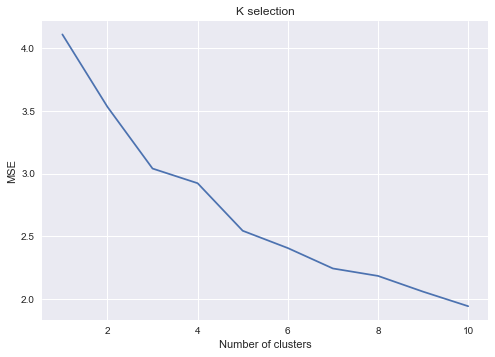

In [36]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [37]:
neighborhoods_venues_sorted.columns

Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [38]:
# Based on the elbow method, K=5 is a good choice for clustering
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
kmeans.labels_[0:50]

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4])

In [39]:
neighborhoods_venues_sorted.columns

Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [40]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Asian Restaurant,Bakery,American Restaurant,Sushi Restaurant,Steakhouse,Hotel,Restaurant
1,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Wine Shop,Plaza,Playground,Pizza Place,Italian Restaurant
2,Berczy Park,Coffee Shop,Italian Restaurant,Cheese Shop,Seafood Restaurant,Bakery,Beer Bar,Steakhouse,Café,Cocktail Bar,Farmers Market
3,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Italian Restaurant,Caribbean Restaurant,Bakery,Furniture / Home Store,Climbing Gym,Restaurant,Grocery Store
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Auto Workshop,Gym / Fitness Center,Fast Food Restaurant,Comic Shop,Brewery,Burrito Place,Smoke Shop,Skate Park,Garden


In [41]:
# Create dataframe that includes the cluster and top 10 venues

# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tony_merged = df

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tony_merged = tony_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tony_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,Sandwich Place,Coffee Shop,Donut Shop,Supplement Shop,Steakhouse,Big Box Store,Miscellaneous Shop,Shopping Mall,Seafood Restaurant,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Vietnamese Restaurant,Cocktail Bar,American Restaurant,Spa,Optical Shop,Salon / Barbershop,Bakery,Bubble Tea Shop,Furniture / Home Store
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Bakery,Café,Mobile Phone Shop,Grocery Store,Spanish Restaurant,Donut Shop,Pizza Place,Coffee Shop,Park,New American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Café,Lounge,Pizza Place,Deli / Bodega,Spanish Restaurant,Restaurant,Frozen Yogurt Shop,Bakery,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Mexican Restaurant,Deli / Bodega,Café,Coffee Shop,Yoga Studio,Donut Shop,Sushi Restaurant,Bakery,School


In [42]:
# display clusters on maps

map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude_mah, longitude_mah], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (latitude_mah, longitude_mah), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (latitude_tor, longitude_tor), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [44]:
# create map
map_clusters = folium.Map(location=[latitude_tor, longitude_tor], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (latitude_mah, longitude_mah), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (latitude_tor, longitude_tor), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

## 6. Cluster Evaluation 

In [53]:
#cluster 1
cluster01=tony_merged.loc[tony_merged['Cluster Labels'] == 0,   tony_merged.columns[[0]+[1]+ list(range(5, tony_merged.shape[1]))]]
cluster01

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,Sandwich Place,Coffee Shop,Donut Shop,Supplement Shop,Steakhouse,Big Box Store,Miscellaneous Shop,Shopping Mall,Seafood Restaurant,Yoga Studio
1,Manhattan,Chinatown,Chinese Restaurant,Vietnamese Restaurant,Cocktail Bar,American Restaurant,Spa,Optical Shop,Salon / Barbershop,Bakery,Bubble Tea Shop,Furniture / Home Store
2,Manhattan,Washington Heights,Bakery,Café,Mobile Phone Shop,Grocery Store,Spanish Restaurant,Donut Shop,Pizza Place,Coffee Shop,Park,New American Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
72,West Toronto,"Little Portugal, Trinity",Bar,Coffee Shop,Men's Store,Restaurant,Asian Restaurant,Vietnamese Restaurant,New American Restaurant,Bakery,French Restaurant,Pizza Place
74,West Toronto,"High Park, The Junction South",Mexican Restaurant,Bar,Thai Restaurant,Café,Italian Restaurant,Cajun / Creole Restaurant,Furniture / Home Store,Discount Store,Diner,Arts & Crafts Store
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Auto Workshop,Gym / Fitness Center,Fast Food Restaurant,Comic Shop,Brewery,Burrito Place,Smoke Shop,Skate Park,Garden


In [54]:
#cluster 2
cluster02=tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[0]+[1] + list(range(5, tony_merged.shape[1]))]]
cluster02

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Manhattan,Financial District,Coffee Shop,Hotel,American Restaurant,Gym,Food Truck,Pizza Place,Event Space,Wine Shop,Café,Gym / Fitness Center
40,East Toronto,The Beaches,Pub,Trail,Health Food Store,Women's Store,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
41,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Brewery,Bakery,Liquor Store,Lounge,Fruit & Vegetable Store
...,...,...,...,...,...,...,...,...,...,...,...,...
73,West Toronto,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Italian Restaurant,Caribbean Restaurant,Bakery,Furniture / Home Store,Climbing Gym,Restaurant,Grocery Store
75,West Toronto,"Parkdale, Roncesvalles",Gift Shop,Coffee Shop,Cuban Restaurant,Restaurant,Eastern European Restaurant,Italian Restaurant,Bookstore,Movie Theater,Bar,Breakfast Spot
76,West Toronto,"Runnymede, Swansea",Coffee Shop,Café,Sushi Restaurant,Italian Restaurant,Pizza Place,Gastropub,Restaurant,Tea Room,Diner,Latin American Restaurant


In [55]:
#cluster 3
cluster03=tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[0]+[1] + list(range(5, tony_merged.shape[1]))]]
cluster03

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Downtown Toronto,Rosedale,Park,Playground,Trail,Women's Store,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
63,Central Toronto,"Forest Hill North, Forest Hill West",Park,Trail,Sushi Restaurant,Jewelry Store,Women's Store,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner


In [56]:
#cluster 4
cluster04=tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[0]+[1] + list(range(5, tony_merged.shape[1]))]]
cluster04

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,Roselawn,Ice Cream Shop,Garden,Women's Store,Empanada Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop


In [57]:
#cluster 5
cluster05=tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[0]+[1] + list(range(5, tony_merged.shape[1]))]]
cluster05

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,"Moore Park, Summerhill East",Playground,Restaurant,Women's Store,English Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop


### Observations:
Most of the neighborhoods fall into Cluster 2 which are mostly business areas with lots of cafe, restaurants, supermarkets etc. Cluster 1 is characterized by its outdoor attractions--parks, playgrounds, trails. Cluster 3 seems a bit of a mix of both cluster 1 and 2 with garden, stores, and fast food and specialty cuisines restaurants.


## 7. Cluster Chart Plot

### Cluster Waffle Chart

In [51]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 500
Cluster I: 353
Cluster II: 122
Cluster III: 13
Cluster IV: 6
Cluster V: 6


<Figure size 576x396 with 0 Axes>

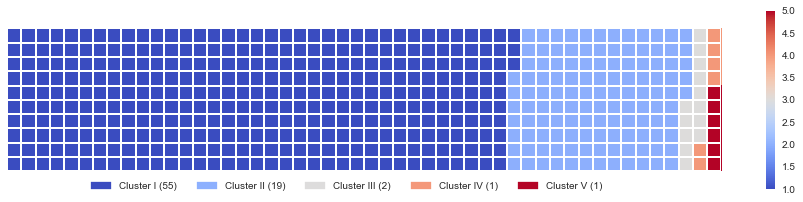

In [60]:
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V']
portions = [cluster01.shape[0], cluster02.shape[0], cluster03.shape[0], cluster04.shape[0], cluster05.shape[0]]
width = 50 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

### Bar Chart for Cluster Insight

In [65]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[0,:]
tmp[1,:] = kmeans.cluster_centers_[1,:]
tmp[2,:] = kmeans.cluster_centers_[2,:]
tmp[3,:] = kmeans.cluster_centers_[3,:]
tmp[4,:] = kmeans.cluster_centers_[4,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

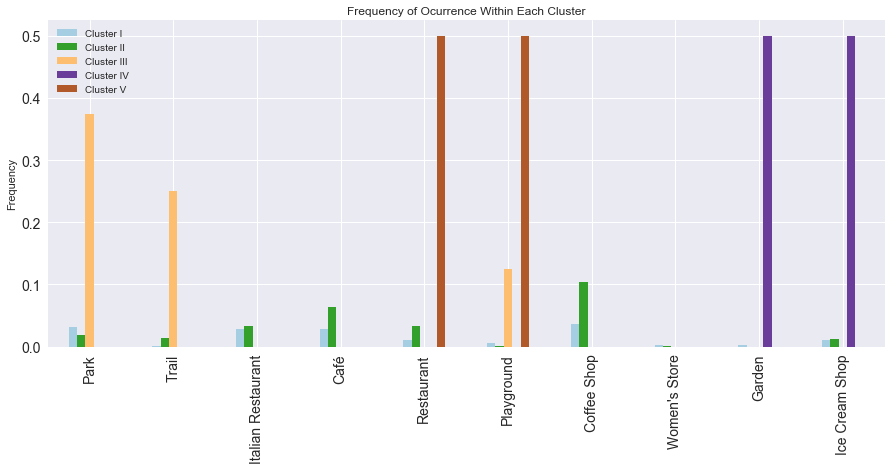

In [66]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

### Observations:
Most of the neighborhoods (55) in Manhatan and Toronto fall into Cluster 1, where there balanced distribution on restraurants, Cafe and playgroundpark. Cluster 2 consists of 19 neighbourhoods from Manhattan and Toronto, where there are a lot of Cafe and coffee shops. There are 3 special Clusters in Toronto. Cluster 3 is characterized by its outdoor attractions: park, trail and playground. Cluster 4 is a special garden-dominated area with plenty of Ice Cream Shops. Cluster 5 is dominated by restraurants and playgrounds. 


![Toronto Vs New York Photo from public website](TorontoVsNewYork02.jpg)